# <span style="color:rgb(106,127,16)">Bikes on Tilikum Crossing</span>


<div style="text-align: right"><span style="color:rgb(106,127,16)">April 30, 2020
    </span></div>
<br>




A car-free bridge is still considered a ridiculous idea in many parts of our country (and some go so far as to call it un-American).  Portlanders beg to differ. Our newest bridge, the *Tilikum Crossing,* opened in 2015, and is highly multimodal,  allowing travel for pedestrians, bikes, electric scooters, trains, streetcars, and buses (but the modality of travel by personal car is missing). Bike lanes were not an afterthought, but rather an integral part of the bridge  design. We therefore expect to see a good amount of bike traffic on Tilikum.  


In this activity, we examine the data collected by the bicycle counters on the Tilikum. Here is a photo of the bike counter (the black display) located in between the streetcar  the  bike lanes on the bridge.

<img src="../figs/TilikumStreecar.png" style="width:400px">

The [BikePed Portal](http://bikeped.trec.pdx.edu) provides some data collected from the counter for the public, but currently only subsampled data can be publicaly downloaded from there.  Here we shall instead use the full raw data set collected by the counters, which is not yet publicly downloadable. I gratefully acknowledge Dr. Tammy Lee and [TREC](https://trec.pdx.edu/) for making this data accessible for our course.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

## Initial examination of the data



As you have seen in previous activities, the first step in dealing with real data is wrangling with it to fit our tools. The case of this data is no different. 


(If you haven't yet heard of Hadley Wickham's famous paper [Tidy Data](https://www.jstatsoft.org/article/view/v059i10), I recommend you take a look. It begins with the sentence, "A huge amount of effort is spent cleaning data to get it ready for analysis $\ldots$")

In [2]:
# metadata file (small file)
tm = pd.read_csv('../../data_external/tilikum_metadata.csv')

# data file (large file)
td = pd.read_csv('../../data_external/tilikum_data_20200427.csv')
td.head()

,id,start_time,end_time,measure_period,volume,flow_detector_id
0,36586735,2015-08-09 08:00:00+00,2015-08-09 08:15:00+00,00:15:00,0,1903
1,36586736,2015-08-09 08:15:00+00,2015-08-09 08:30:00+00,00:15:00,0,1903
2,36586737,2015-08-09 08:30:00+00,2015-08-09 08:45:00+00,00:15:00,0,1903
3,36586738,2015-08-09 08:45:00+00,2015-08-09 09:00:00+00,00:15:00,0,1903
4,36586739,2015-08-09 09:00:00+00,2015-08-09 09:15:00+00,00:15:00,0,1903


Looking through first few (of the over 300,000) data entries above, and then examining the meta data file contents in `tm`, we conclude that `volume`  gives the bike counts. The volume is for 15-minute intervals as seen from `measure_period`. A quick check indicates that every data  entry has a starting and ending time that conforms to a 15-minute measurement.

In [3]:
dif = pd.to_datetime(td['end_time']) - pd.to_datetime(td['start_time']) 
(dif == dif[0]).all()

True

Therefore, let us rename `start_time` to just `time` and drop the redundant data in `end_time` and `measure_period` (as well as the `id`) columns. 

In [4]:
td = td.rename(columns={'start_time':'time'}).drop(columns=['end_time', 'measure_period', 'id'])

The meta data also tells us to expect three detectors and hence three values of `flow_detector_id`. One of these values never seems to appear in the data.

In [5]:
(td.flow_detector_id==1904).sum()

0

Therefore, going through the meta data again, we conclude that eastbound and westbound bikes pass through the flow detectors with id-numbers 1903 and 1905, respectively. Portland is divided into east and west by the Willamette river and the Tilikum connects the two sides with both eastbound and westbound lanes.


The next step is to reshape the data into the form of a  time series. The `start_time` seems like a good candidate for indexing a time series. But it's  a red herring.  A closer look will tell you that the times are repeated in the data set. This is because there are distinct data entries for the eastbound and westbound volumes with the same time stamp. So we will make two data sets (since our data is not gigabytes long,  memory will not be an issue),  a `tE` for eastbound volume and `tW` for westbound volume.  

In [6]:
tE = td.loc[td['flow_detector_id']==1903, ['time', 'volume']]
tE.index = pd.DatetimeIndex(pd.to_datetime(tE['time'])).tz_convert('US/Pacific')
tE = tE.drop(columns=['time']).rename(columns={'volume':'Eastbound'})

In [7]:
tW = td.loc[td['flow_detector_id']==1905, ['time', 'volume']]
tW.index = pd.DatetimeIndex(pd.to_datetime(tW['time'])).tz_convert('US/Pacific')
tW = tW.drop(columns=['time']).rename(columns={'volume':'Westbound'})

Note that we have now indexed eastbound and westbound data by time stamps, and  renamed `volume` to `Eastbound` and `Westbound` respectively in each case. 


We are now ready for a first look at the full time series. Let us consider the eastbound data first.

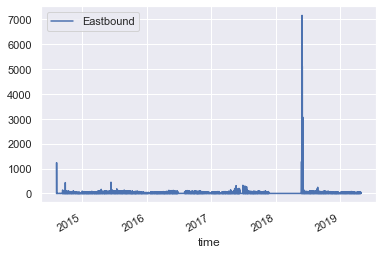

In [8]:
tE.plot();

Clearly, we have problems with this data. A spike of 7000 bikers passing through in 15 minutes, even for a bike-crazed city like Portland, just does not seem right. Zooming in, we find the situation even more disturbing, with a lot of zero readings before the spike: 

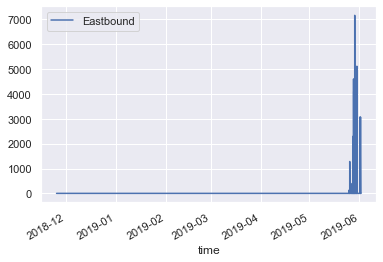

In [9]:
tE['2018-11-25':'2019-06-01'].plot();

There are reports from [TriMet](https://trimet.org) of construction in 2018 affecting bike counters, but without more specific information about the dates affected, we are forced to come up with some strategy ourselves for discarding false-looking entries from the data.


First,  exploiting `pandas`' ability to work with missing values, we declare the values in the dates in the above plot to be missing.

In [10]:
tE['2018-11-25':'2019-06-01'] = np.nan

Next, we shall declare all entries with a volume of more than 1000 bikes per 15 minute to be a missing value on both the west abd east bound data. 

In [11]:
tE[tE > 1000] = np.nan
tW[tW > 1000] = np.nan

The westbound counter seems a little better, but we will still limit the data to entries with volume less than 1000.

Next, we merge east and west two data sets on the same timestamp axis. 

In [12]:
t = pd.merge(tE, tW, on='time')

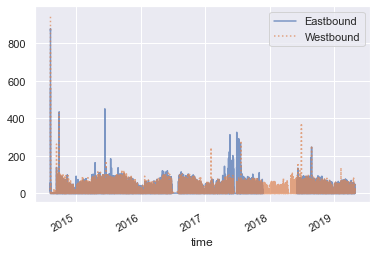

In [13]:
t.plot(alpha=0.7, style=['-',':']);

Examining the above graph, we still see spikes that look unreasonably high in the beginning of the data, but they may actually be real because  at the official [opening of the bridge](https://www.oregonlive.com/multimedia/2015/08/tilikum_crossing_public_treate.html)  there were 30,000 to 40,000 people and at least 13,000 bikes milling around. Similarly, the other spikes may be real data. One can try to explain them, e.g.,  by consulting https://bikeportland.org/events/, from which you might conclude that the spike on August 25, 2019 is due to a [Green Loop](https://bikeportland.org/event/sunday-parkways-green-loop-downtown) event, and the spike on June 29, 2019 might be due to all the people coming over for the World Naked Bike Ride. We'll just leave it at that, and blame the spikes on the groovy bike scene of Portland.

## The pattern of use

As a first peep into the data, we shall plot the distribution of weekend riders and weekday riders. This is motivated by the time series exampe in your textbook, which I highly recommend that you read, if you have not already.

The Tilikum is being used both by people who commute to work using a bicyle as well as recreational bicycle users. This division is clear when we divide the data into weekend and weekday trips.

In [14]:
def weekplot(d, onlyweekend=False, title=None):
    weekend = np.where(d.index.weekday < 5, 'Weekday', 'Weekend')
    by_time = d.groupby([weekend, d.index.time]).mean()
    if onlyweekend: 
        if title is None: title = 'Weekend 15-min distribution'
        by_time.loc['Weekend'].plot(title=title)
    else:
        if title is None: title = 'Weekday 15-min distribution'
        by_time.loc['Weekday'].plot(title=title)

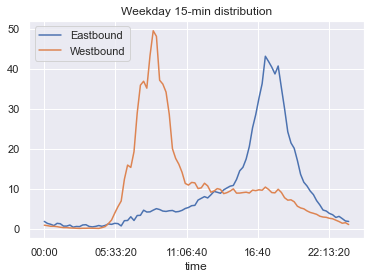

In [15]:
weekplot(t)

The hourly distribution is distinctly "bimodal": there is a group of westbound commuters in the morning and a group (probably the same people) traveling eastbound after work. If you look closely, you will find that there is a slightly smaller bump indicating that there are some eastbound bikers in the morning who return across the bridge in the evening. Yet, the data leads us to the interesting conclusion that the overwhelming majority of the **bike commuters on the Tilikum live on the east side and commute to the west.** 

If the purpose of understanding data is to guide policy and action, then I would argue that as long as the above trend in the data continues, then the city and the policy makers might want to consider a peak-hour widening of the respective bike-lanes to optimize utilization.

Next, let us look at the non-commuter, recreational, use in the weekends. This distribution has just one peak in sharp contrast to the  weekday distribution.

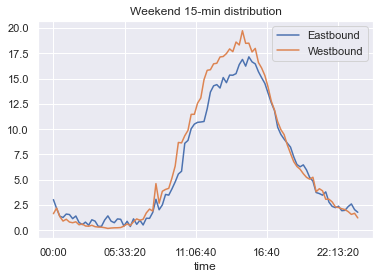

In [16]:
weekplot(t, onlyweekend=True)

## Changes due to isolation

As we already know, on March 18, 2020, in-person instructional activities at universities in Oregon were suspended, and  on March 23, 2020, Oregon governor issued the ["Stay Home, Save Lives" executive order](https://govsite-assets.s3.amazonaws.com/jkAULYKcSh6DoDF8wBM0_EO%2020-12.pdf). Since the  Tilikum is near two major universities in Portland, we expect the weekday bike traffic to be impacted by these measures. Let us examine what the data tells us. 

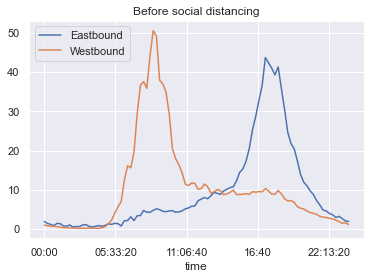

In [17]:
weekplot(t.loc[:'2020-03-17'], title='Before social distancing')

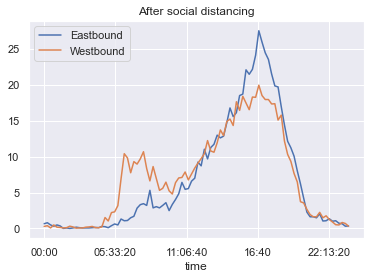

In [18]:
weekplot(t.loc['2020-03-17':], title='After social distancing')

Clealry, the strong bimodal distribution has weakened considerably after we all started isolating ourselves. This is no surprise, since the universities on the west side of Tilikum, like us,  have switched to remote classes, so it make sense that there are few westbound commuters in the morning.

What I could not have guessed without the data is the extent of the continued bike traffic on the bridge from 3 to 5 pm. One could imagine various explanations for this: people get tired of isolating themselves all morning, get restless in the afternoon, especially with such unsually good weather we are having these days, and decide to take their bikes out for a spate of fresh air. 

To summarize our second conclusion from the data,  **social distancing has changed the weekday bike use on Tilikum from a commuter to a recreational pattern.**    



<hr>




<span style="color:rgb(106,127,16); font-size:8pt">These materials were created by</span> [<span style="color:rgb(106,127,16); font-size:8pt">Jay Gopalakrishnan</span>](http://web.pdx.edu/~gjay/) <span style="color:rgb(106,127,16); font-size:8pt">for a sophomore course (MTH 271) offered during the Spring 2020 quarter at Portland State University, and are made available under the</span> [<span style="color:rgb(106,127,16) ; font-size:8pt">CC-BY-SA license</span>](https://creativecommons.org/licenses/by-sa/4.0/legalcode).
 




